# Implementing One Class SVM for Outlier Detection


One-Class Support Vector Machine (SVM) is an unsupervised model for anomaly or outlier detection. Unlike the regular supervised SVM, the one-class SVM does not have target labels for the model training process. Instead, it learns the boundary for the normal data points and identifies the data outside the border to be anomalies. 

In this post, we will use Python's sklearn library to implement one-class SVM. we will learn the following after reading the post
* How to train a one-class support vector machine (SVM) model
* How to predict anomalies from a one-class SVM model
* How to change the default threshold for anomaly prediction
* How to visualize the prediction results



Import Libraries

In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt

# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report


Create Imbalanced Dataset

Using `make_classification` from the `sklearn` library, We created two classes with the ratio between the majority class and the minority class being 0.995:0.005. Two informative features were made as predictors. We did not include any redundant or repeated features in this dataset.

In [2]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# Check the target distribution
df['target'].value_counts(normalize = True)

0    0.9897
1    0.0103
Name: target, dtype: float64

The output shows that we have about 1% of the data in the minority class and 99% in the majority class.

Train Test Split

In this step, we split the dataset into 80% training data and 20% validation data. random_state ensures that we have the same train test split every time. The seed number for random_state does not have to be 42, and it can be any number.

In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79183 records for the majority class and 817 records for the minority class.


The train test split gives us 80,000 records for the training dataset and 20,000 for the validation dataset. Thus, we have 79,183 data points from the majority class and 817 from the minority class in the training dataset.


Train One-Class Support Vector Machine (SVM) Model

When training the one-class SVM, there are a few critical hyperparameters.
* `nu` is to specify the percentage of anomalies. `nu=0.01` means that we have around 1% outliers in the dataset.
* Kernel specifies the kernel type. The radial basis function (`rbf`) kernel is a commonly used kernel type. It maps data from a low dimensional space to a high dimensional space to help the SVM model draw a decision boundary.
* `gamma` is a kernel coefficient, and it is for `'rbf'`, `'poly'`, and `'sigmoid'` kernels. When setting it to `'auto'`, the kernel coefficient is 1 over the number of features.

In [4]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

# lets Predict Anomalies

After training the one-class SVM model on the training dataset, we make predictions on the testing dataset. By default, one-class SVM labels the normal data points as 1s and anomalies as -1s. To compare the labels with the ground truth in the testing dataset, we changed the anomalies' labels from -1 to 1, and the normal labels from 1 to 0.

In [5]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)

# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]

# Check the model performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19787
           1       0.06      0.06      0.06       213

    accuracy                           0.98     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.98      0.98      0.98     20000



The model has a recall values of 6%, meaning that it captures 6% of the anomaly data points.

## Customize Predictions Using Scores

Instead of using the default threshold for identifying outliers, we can customize the threshold and label more or fewer data points as outliers. For example, in the code below, we find the score for 2% of the data points and use it as the prediction threshold.

In [6]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)

# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')

The customized score threshold for 2% of outliers is 182.62


In [7]:
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]

# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19787
           1       0.06      0.10      0.07       213

    accuracy                           0.97     20000
   macro avg       0.52      0.54      0.53     20000
weighted avg       0.98      0.97      0.98     20000



The recall value increased from 6% to 10% because we increased the threshold for anomalies.

### Visualization

This step will plot the data points and check the differences between actual, one-class SVM prediction and customized one-class SVM prediction.

In [8]:
type(X_test)

numpy.ndarray

In [9]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction

In [10]:
df_test.head()

,feature1,feature2,y_test,one_class_svm_prediction,one_class_svm_prediction_cutomized
0,-0.387675,0.374149,0,0,0
1,-0.617411,0.377246,0,0,0
2,0.431764,0.191341,0,0,0
3,-1.151505,0.386460,0,0,0
4,-0.150023,0.538970,0,0,0


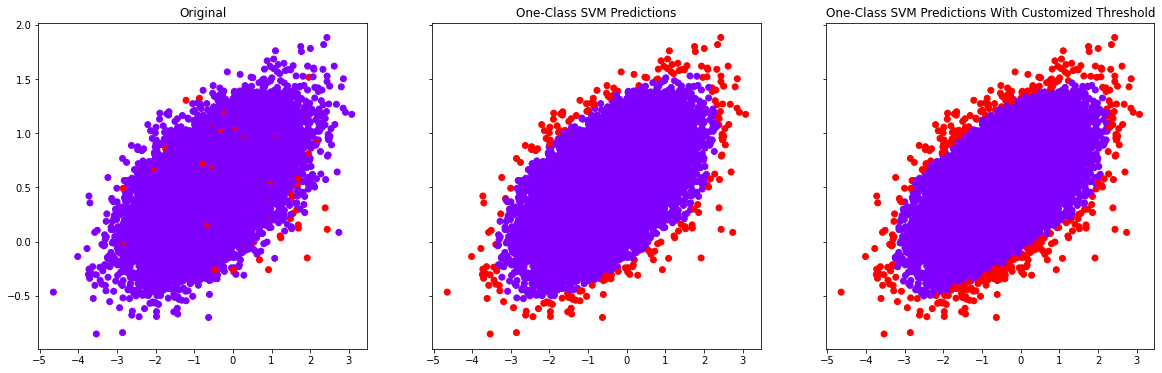

In [11]:
# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))

# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')

# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow')

We can see that one-class SVM has a clear boundary and labeled the data points out of the boundary to be anomalies. When we increase the threshold for the score, more data points are labels as anomalies.

### References

* [One Class SVM Paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.86.5955&rep=rep1&type=pdf)
* [Anomaly Detection Sklearn User Guide](https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection)
* [One-class SVM With Non-linear Kernel](https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py)
